In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import os
import json
import itertools
import concurrent.futures
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# ✅ Enable GPU acceleration & mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

### --- 1. Load & Preprocess Data --- ###
def load_data(stock_code, start_date = '2014-01-01', end_date = '2024-12-31'):
    df = yf.download(stock_code, start=start_date, end=end_date)
    df = df.copy().reset_index()
    df['log_close'] = np.log(df['Close'])  # Log transform to handle unbounded prices
    return df
def scale_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[['log_close']])
    return df_scaled, scaler

### --- 2. Create Train & Test Sets --- ###
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

def prepare_train_test(df_scaled, lookback, train_size=0.8):
    split = int(len(df_scaled) * train_size)
    train, test = df_scaled[:split], df_scaled[split:]
    X_train, y_train = create_sequences(train, lookback)
    X_test, y_test = create_sequences(test, lookback)

    # ✅ Use tf.data for faster training
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

    return X_train, y_train, X_test, y_test, train_dataset, test_dataset

### --- 3. Build LSTM Model (Using CuDNN for Speed) --- ###
def build_lstm_model(lookback, units, dropout_rate, learning_rate):
    model = Sequential([tf.keras.Input(shape=(lookback, 1)),
        # LSTM(units, return_sequences=True, input_shape=(lookback, 1)),
        LSTM(units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, dtype=tf.float32)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

### --- 4. Train Model with Callbacks --- ###
def train_model(model, train_dataset, test_dataset, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    history = model.fit(train_dataset, validation_data=test_dataset,
                        epochs=epochs, callbacks=[early_stopping, reduce_lr], verbose=0)
    return history

### --- 5. Evaluate RMSE & Detect Overfitting --- ###
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Convert back to original stock price scale
    y_train_original = np.exp(scaler.inverse_transform(y_train.reshape(-1, 1)))
    y_test_original = np.exp(scaler.inverse_transform(y_test.reshape(-1, 1)))
    train_pred_original = np.exp(scaler.inverse_transform(train_pred))
    test_pred_original = np.exp(scaler.inverse_transform(test_pred))

    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_pred_original))

    print(f"✅ Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

    if train_rmse < test_rmse * 0.8:
        print("⚠️ Overfitting detected! Consider adding dropout or reducing LSTM units.")
    elif train_rmse > test_rmse * 1.2:
        print("⚠️ Underfitting detected! Consider increasing LSTM units or learning rate.")
    else:
        print("✅ Model is well-fitted.")

    return train_rmse, test_rmse

### --- 6. Plot Loss Curves --- ###
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Train vs Validation Loss")
    plt.show()

### --- 7. Parallel Grid Search & Auto Model Selection --- ###
def train_model_with_params(params, filename, lookback):
    units, dropout_rate, learning_rate, batch_size = params
    df = load_data(filename)
    df_scaled, scaler = scale_data(df)
    X_train, y_train, X_test, y_test, train_dataset, test_dataset = prepare_train_test(df_scaled, lookback)

    print(f"Training with units={units}, dropout={dropout_rate}, lr={learning_rate}, batch={batch_size}")

    model = build_lstm_model(lookback, units, dropout_rate, learning_rate)
    history = train_model(model, train_dataset, test_dataset, epochs=100)
    train_rmse, test_rmse = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
    plot_loss(history)

    return (params, test_rmse, train_rmse, model)

def parallel_grid_search(filename, lookback, param_grid):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    hyperparam_combinations = list(itertools.product(*param_grid.values()))
    best_rmse = float("inf")
    best_params = None
    best_model = None

    # ✅ Parallel training with ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(lambda p: train_model_with_params(p, filename, lookback), hyperparam_combinations))

    for params, test_rmse, train_rmse, model in results:
        if test_rmse < best_rmse and abs(train_rmse - test_rmse) < 5:  # Favor generalization
            best_rmse = test_rmse
            best_params = params
            best_model = model

    # Save best model
    if best_model is not None:
      best_model.save(f"models/best_lstm_lookback_{lookback}.h5")

    # Save best hyperparameters
    results_dict = {
        "lookback": lookback,
        "best_units": best_params[0],
        "best_dropout": best_params[1],
        "best_learning_rate": best_params[2],
        "best_batch_size": best_params[3],
        "best_test_rmse": best_rmse
    }
    with open(f"results/best_params_lookback_{lookback}.json", "w") as f:
        json.dump(results_dict, f)

    print(f"✅ Best model saved with RMSE={best_rmse:.2f}")

In [3]:
### --- 8. Run Optimized Training --- ###
lookback_periods = [5, 10, 20, 30, 60]

# Define hyperparameter grid
param_grid = {
    "units": [32, 50, 100],
    "dropout_rate": [0.2, 0.3, 0.4],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32]
}

In [19]:
### --- 999. Run Manual Training --- ###
lookback_periods = [60,30,10,5]

# Define hyperparameter grid
param_grid = {
    "units": [128,64],
    "dropout_rate": [0.9],
    "learning_rate": [0.0001],
    "batch_size": [32]
}

[*********************100%***********************]  1 of 1 completed



Training with units=64, dropout=0.9, lr=0.0001, batch=32Training with units=128, dropout=0.9, lr=0.0001, batch=32


Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
✅ Train RMSE: 34.85 | Test RMSE: 62.15
⚠️ Overfitting detected! Consider adding dropout or reducing LSTM units.


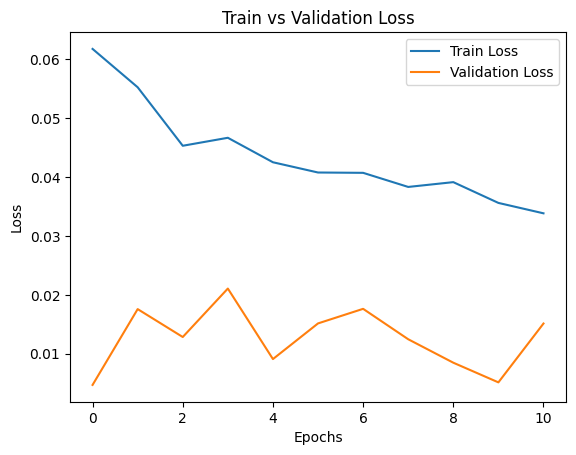


Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
✅ Train RMSE: 15.80 | Test RMSE: 30.55
⚠️ Overfitting detected! Consider adding dropout or reducing LSTM units.


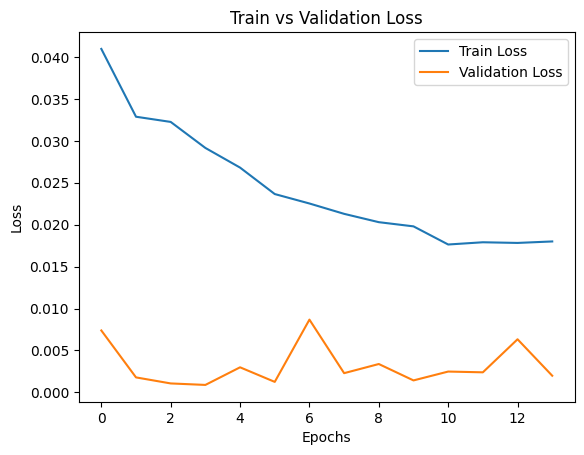

TypeError: 'NoneType' object is not subscriptable

In [20]:
for lookback in lookback_periods:
    parallel_grid_search('TSLA', lookback, param_grid)

In [ ]:
# ✅ Enable GPU & mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

### --- 1. Load & Preprocess Data --- ###
def load_data(stock_code, start_date = '2014-01-01', end_date = '2024-12-31'):
    df = yf.download(stock_code, start=start_date, end=end_date)
    df = df.copy().reset_index()
    df['log_close'] = np.log(df['Close'])  # Log transform to handle unbounded prices
    return df

def scale_data(df, scaler_type='MinMax'):
    if scaler_type == 'MinMax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaler_type == 'Standard':
        scaler = StandardScaler()

    df_scaled = scaler.fit_transform(df[['log_close']])
    return df_scaled, scaler

### --- 2. Create Train & Test Sets --- ###
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

def prepare_train_test(df_scaled, lookback, train_size=0.8):
    split = int(len(df_scaled) * train_size)
    train, test = df_scaled[:split], df_scaled[split:]
    X_train, y_train = create_sequences(train, lookback)
    X_test, y_test = create_sequences(test, lookback)

    # ✅ Use tf.data for faster training
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

    return X_train, y_train, X_test, y_test, train_dataset, test_dataset

### --- 3. Build LSTM Model --- ###
def build_lstm_model(lookback, units, dropout_rate, learning_rate, regularization):
    model = Sequential([tf.keras.Input(shape=(lookback, 1)),
        LSTM(units, return_sequences=True,
            #  input_shape=(lookback, 1),
                  kernel_regularizer=l1_l2(l1=regularization, l2=regularization)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, dtype=tf.float32)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

### --- 4. Train Model with Callbacks --- ###
def train_model(model, train_dataset, test_dataset, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    history = model.fit(train_dataset, validation_data=test_dataset,
                        epochs=epochs, callbacks=[early_stopping, reduce_lr], verbose=0)
    return history

### --- 5. Evaluate RMSE & Store Results --- ###
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Convert back to original scale
    y_train_original = np.exp(scaler.inverse_transform(y_train.reshape(-1, 1)))
    y_test_original = np.exp(scaler.inverse_transform(y_test.reshape(-1, 1)))
    train_pred_original = np.exp(scaler.inverse_transform(train_pred))
    test_pred_original = np.exp(scaler.inverse_transform(test_pred))

    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_pred_original))

    return train_rmse, test_rmse

### --- 6. Store Model & Performance --- ###
def save_model_results(model, params, train_rmse, test_rmse, lookback):
    model_dir = "models"
    results_dir = "results"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

    # Save Model
    model_path = f"{model_dir}/lstm_{lookback}_{params['units']}_{params['dropout']}_{params['lr']}.h5"
    model.save(model_path)

    # Save Results
    result = {
        "lookback": lookback,
        "units": params["units"],
        "dropout": params["dropout"],
        "learning_rate": params["lr"],
        "regularization": params["regularization"],
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "model_path": model_path
    }

    results_path = f"{results_dir}/results.csv"
    if os.path.exists(results_path):
        df_results = pd.read_csv(results_path)
        df_results = df_results.append(result, ignore_index=True)
    else:
        df_results = pd.DataFrame([result])

    df_results.to_csv(results_path, index=False)

### --- 7. Parallel Grid Search --- ###
def train_model_with_params(params, filename, lookback):
    df = load_data(filename)
    df_scaled, scaler = scale_data(df, scaler_type='MinMax')
    X_train, y_train, X_test, y_test, train_dataset, test_dataset = prepare_train_test(df_scaled, lookback)

    model = build_lstm_model(lookback, params['units'], params['dropout'], params['lr'], params['regularization'])
    history = train_model(model, train_dataset, test_dataset, epochs=100)
    train_rmse, test_rmse = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)

    save_model_results(model, params, train_rmse, test_rmse, lookback)
    return params, train_rmse, test_rmse

def parallel_grid_search(filename, lookback, param_grid):
    param_combinations = list(itertools.product(*param_grid.values()))
    param_dicts = [{"units": u, "dropout": d, "lr": lr, "regularization": r} for u, d, lr, r in param_combinations]

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(lambda p: train_model_with_params(p, filename, lookback), param_dicts)

### --- 8. View Results --- ###
def load_results():
    results_path = "results/results.csv"
    if os.path.exists(results_path):
        return pd.read_csv(results_path)
    return pd.DataFrame()

def plot_rmse():
    df_results = load_results()
    if df_results.empty:
        print("No results found.")
        return

    plt.figure(figsize=(10, 5))
    plt.scatter(df_results['lookback'], df_results['test_rmse'], label='Test RMSE', color='blue')
    plt.scatter(df_results['lookback'], df_results['train_rmse'], label='Train RMSE', color='red')
    plt.xlabel("Lookback Period")
    plt.ylabel("RMSE")
    plt.title("RMSE Across Lookback Periods")
    plt.legend()
    plt.show()

In [ ]:
### --- 9. Run Optimized Training --- ###
lookback_periods = [5, 10, 20, 30, 60]

param_grid = {
    "units": [32, 50, 100],
    "dropout": [0.2, 0.3, 0.4],
    "lr": [0.001, 0.0005],
    "regularization": [1e-5, 1e-4]
}

In [ ]:
### --- 9. Run Optimized Training --- ###
lookback_periods = [5]

param_grid = {
    "units": [32],
    "dropout": [0.2],
    "lr": [0.001],
    "regularization": [1e-5]
}

In [ ]:
for lookback in lookback_periods:
    parallel_grid_search('TSLA', lookback, param_grid)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed




Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[*********************100%***********************]  1 of 1 completed

 1/69 ━━━━━━━━━━━━━━━━━━━━ 50s 742ms/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[*********************100%***********************]  1 of 1 completed


Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
10/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


[*********************100%***********************]  1 of 1 completed



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
64/69 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed





Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
62/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


12/69 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

[*********************100%***********************]  1 of 1 completed

48/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 1/69 ━━━━━━━━━━━━━━━━━━━━ 40s 589ms/step

61/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

[*********************100%***********************]  1 of 1 completed

68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
52/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


[*********************100%***********************]  1 of 1 completed

 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
48/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
45/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

65/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed




Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
66/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed






Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
63/69 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 34: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 39: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
64/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   

59/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

[*********************100%***********************]  1 of 1 completed

65/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
66/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
19/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
37/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
59/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed






Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[*********************100%***********************]  1 of 1 completed


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

[*********************100%***********************]  1 of 1 completed

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 25: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


14/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

[*********************100%***********************]  1 of 1 completed

22/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
46/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


[*********************100%***********************]  1 of 1 completed


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[*********************100%***********************]  1 of 1 completed

12/69 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[*********************100%***********************]  1 of 1 completed


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


[*********************100%***********************]  1 of 1 completed


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed






Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[*********************100%***********************]  1 of 1 completed

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 23: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 28: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


23/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

[*********************100%***********************]  1 of 1 completed

49/68 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   

30/68 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

[*********************100%***********************]  1 of 1 completed

36/68 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

[*********************100%***********************]  1 of 1 completed

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



[*********************100%***********************]  1 of 1 completed



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 26: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
64/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
63/68 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 26: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


[*********************100%***********************]  1 of 1 completed


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
load_results()

,lookback,units,dropout,learning_rate,regularization,train_rmse,test_rmse,model_path
0,5,32,0.2,0.001,0.00001,16.999553,33.404175,models/lstm_5_32_0.2_0.001.h5


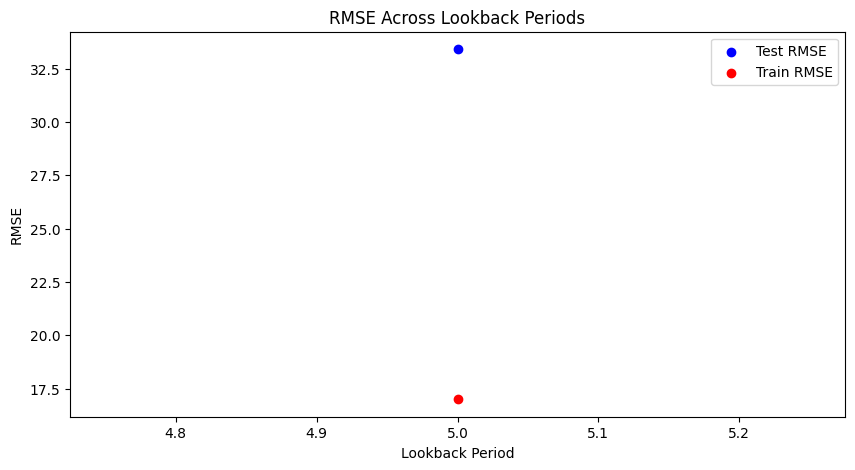

In [ ]:
plot_rmse()

In [ ]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures

In [ ]:
# Download TSLA stock data (only once)
DATA_PATH = "tsla_processed.csv"
if not os.path.exists(DATA_PATH):
    tsla = yf.download("TSLA", start="2014-01-01", end="2025-01-01")
    tsla = tsla.copy()
    tsla.columns = [col[0] for col in tsla.columns]

    tsla["log_close"] = np.log(tsla["Close"])  # Log transform
    scaler = MinMaxScaler(feature_range=(0, 1))
    tsla["scaled_close"] = scaler.fit_transform(tsla[["log_close"]])
    tsla.to_csv(DATA_PATH)
else:
    tsla = pd.read_csv(DATA_PATH, index_col=0)

# Load Preprocessed Data
data_scaled = tsla["scaled_close"].values

In [ ]:
def create_sequences(data, lookback):
    """Generate training and testing sequences."""
    X, y = [], []
    for i in range(len(data) - lookback - 1):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

def get_train_test_split(data, lookback):
    """Create train-test split with the last 12 months as test."""
    X, y = create_sequences(data, lookback)
    train_size = len(y) - 12
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:]

In [ ]:
def build_lstm_model(input_shape, units, dropout, lr, regularization):
    """Build and compile an LSTM model optimized for GPU acceleration."""
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(units, activation="tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(regularization)),
        Dropout(dropout),
        LSTM(units // 2, activation="tanh", return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

In [ ]:
def classify_model_fit(train_rmse, test_rmse, threshold=1.5):
    """Classify model as Overfit, Underfit, or Well-fit."""
    if train_rmse > 30 and test_rmse > 30:
        return "Underfit"
    elif test_rmse > train_rmse * threshold:
        return "Overfit"
    else:
        return "Well-fit"

def save_model_results(model, params, train_rmse, test_rmse, lookback):
    """Save model, hyperparams, RMSE scores, and classification."""
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    model_path = f"models/lstm_{lookback}_{params['units']}_{params['dropout']}_{params['lr']}.keras"
    model.save(model_path)
    fit_quality = classify_model_fit(train_rmse, test_rmse)

    result = {
        "lookback": lookback, **params, "train_rmse": train_rmse,
        "test_rmse": test_rmse, "fit_quality": fit_quality, "model_path": model_path
    }
    df_result = pd.DataFrame([result])
    results_path = "results.csv"
    df_results = pd.read_csv(results_path) if os.path.exists(results_path) else pd.DataFrame()
    df_results = pd.concat([df_results, df_result])
    df_results.to_csv(results_path, index=False)

In [ ]:
# def train_model_with_params(params, lookback):
#     """Train model with given hyperparameters and store results."""
#     X_train, y_train, X_test, y_test = get_train_test_split(data_scaled, lookback)
#     model = build_lstm_model((lookback, 1), **params)

#     callbacks = [
#         EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
#         ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10)
#     ]

#     history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
#                         epochs=100, batch_size=32, callbacks=callbacks, verbose=0)

#     train_rmse = np.sqrt(history.history["loss"][-1])
#     test_rmse = np.sqrt(history.history["val_loss"][-1])

#     save_model_results(model, params, train_rmse, test_rmse, lookback)

def train_model_with_params(params, lookback):
    """Train model with given hyperparameters and store results."""
    X_train, y_train, X_test, y_test = get_train_test_split(data_scaled, lookback)
    model = build_lstm_model((lookback, 1), **params)

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10)
    ]

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=EPOCHS, batch_size=32, callbacks=callbacks, verbose=0)

    train_rmse = np.sqrt(history.history["loss"][-1])
    test_rmse = np.sqrt(history.history["val_loss"][-1])

    save_model_results(model, params, train_rmse, test_rmse, lookback)

In [ ]:
# def adjust_hyperparameter_grid():
#     """Dynamically update hyperparameter grid based on past results."""
#     results_path = "results.csv"

#     param_grid = {
#         "units": [50, 100, 150], "dropout": [0.2, 0.3, 0.4],
#         "lr": [0.001, 0.0005, 0.0001], "regularization": [0.0001, 0.0005, 0.001]
#     }

#     # param_grid = {
#     #     "units": [50], "dropout": [0.2],
#     #     "lr": [0.001], "regularization": [0.0001]
#     # }

#     if not os.path.exists(results_path):
#         return param_grid  # Use default grid if no previous results

#     df_results = pd.read_csv(results_path)

#     overfit_count = sum(df_results["fit_quality"] == "Overfit")
#     underfit_count = sum(df_results["fit_quality"] == "Underfit")

#     if overfit_count > underfit_count:
#         param_grid["dropout"] = [0.4, 0.5, 0.6]
#         param_grid["regularization"] = [0.0005, 0.001, 0.005]
#         param_grid["units"] = [50, 75, 100]
#         param_grid["lr"] = [0.0005, 0.0001]
#     elif underfit_count > overfit_count:
#         param_grid["dropout"] = [0.1, 0.2, 0.3]
#         param_grid["regularization"] = [0.0001, 0.0003]
#         param_grid["units"] = [100, 150, 200]
#         param_grid["lr"] = [0.001, 0.002]

#     return param_grid

In [ ]:
# def parallel_grid_search(lookback):
#     """Run grid search in parallel with automatic hyperparameter adjustment."""
#     param_grid = adjust_hyperparameter_grid()
#     # param_grid = {
#     #     "units": [5, 50, 100, 200], "dropout": [0.2],
#     #     "lr": [0.001], "regularization": [0.0001]
#     # }
#     param_combinations = [{"units": u, "dropout": d, "lr": lr, "regularization": r}
#                           for u, d, lr, r in itertools.product(*param_grid.values())]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#         executor.map(lambda p: train_model_with_params(p, lookback), param_combinations)

def parallel_grid_search():
    """Run grid search in parallel using predefined hyperparameters."""
    param_combinations = [
        {"units": u, "dropout": d, "lr": lr, "regularization": r}
        for u, d, lr, r in itertools.product(*HYPERPARAMETER_GRID.values())
    ]

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        for lookback in LOOKBACK_PERIODS:
            executor.map(lambda p: train_model_with_params(p, lookback), param_combinations)


In [ ]:
# def view_results():
#     df_results = pd.read_csv("results.csv") if os.path.exists("results.csv") else None
#     return df_results.sort_values(by=["test_rmse"]) if df_results is not None else None

# def plot_fit_quality():
#     df_results = pd.read_csv("results.csv")
#     sns.scatterplot(data=df_results, x="lookback", y="test_rmse", hue="fit_quality", palette={"Underfit": "red", "Overfit": "blue", "Well-fit": "green"})
#     plt.show()

In [ ]:
def load_results():
    """Load stored results from CSV."""
    results_path = "results.csv"
    return pd.read_csv(results_path) if os.path.exists(results_path) else None

In [ ]:
def plot_hyperparameter_vs_rmse():
    """Visualize how hyperparameters affect RMSE."""
    if df_results is None:
        print("No results found.")
        return

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df_results, x="lookback", y="test_rmse", hue="fit_quality", size="units", palette="coolwarm")
    plt.title("Lookback vs. Test RMSE with Hyperparameter Influence")
    plt.xlabel("Lookback Period (Days)")
    plt.ylabel("Test RMSE")
    plt.legend(title="Fit Quality")
    plt.show()

In [ ]:
def plot_rmse_over_lookback():
    """Show RMSE trends over different lookback periods."""
    if df_results is None:
        print("No results found.")
        return

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_results, x="lookback", y="test_rmse", marker="o", label="Test RMSE")
    sns.lineplot(data=df_results, x="lookback", y="train_rmse", marker="s", label="Train RMSE", linestyle="dashed")
    plt.xlabel("Lookback Period (Days)")
    plt.ylabel("RMSE")
    plt.title("Train vs Test RMSE Over Lookback Periods")
    plt.legend()
    plt.show()

In [ ]:
def plot_fit_quality_distribution():
    """Bar plot to show the distribution of Overfit, Underfit, Well-fit models."""
    if df_results is None:
        print("No results found.")
        return

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_results, x="fit_quality", palette={"Underfit": "red", "Overfit": "blue", "Well-fit": "green"})
    plt.title("Distribution of Fit Quality")
    plt.xlabel("Fit Classification")
    plt.ylabel("Count")
    plt.show()

In [ ]:
def load_forecast_results():
    """Load stored predictions and actual prices."""
    forecast_path = "forecast_results.csv"
    return pd.read_csv(forecast_path) if os.path.exists(forecast_path) else None

In [ ]:
def plot_forecast_vs_actual(lookback_period):
    """Plot actual vs. predicted prices for a specific lookback period."""
    if df_forecast is None:
        print("No forecast results found.")
        return

    df_filtered = df_forecast[df_forecast["lookback"] == lookback_period]

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered["date"], df_filtered["actual_price"], label="Actual Price", color="black", linestyle="dashed")
    plt.plot(df_filtered["date"], df_filtered["predicted_price"], label="Predicted Price", color="blue")
    plt.fill_between(df_filtered["date"], df_filtered["lower_bound"], df_filtered["upper_bound"],
                     color="blue", alpha=0.2, label="Confidence Interval")

    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"TSLA Forecast vs. Actual Prices (Lookback: {lookback_period} days)")
    plt.legend()
    plt.show()

In [ ]:
def plot_prediction_errors():
    """Plot distribution of prediction errors for different lookback periods."""
    if df_forecast is None:
        print("No forecast results found.")
        return

    df_forecast["error"] = df_forecast["predicted_price"] - df_forecast["actual_price"]

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_forecast, x="lookback", y="error", palette="coolwarm")
    plt.axhline(0, linestyle="dashed", color="black", alpha=0.5)
    plt.title("Prediction Errors Across Lookback Periods")
    plt.xlabel("Lookback Period (Days)")
    plt.ylabel("Prediction Error")
    plt.show()

In [ ]:
def plot_forecast_performance():
    """Plot RMSE of predictions over time to see model stability."""
    if df_forecast is None:
        print("No forecast results found.")
        return

    df_performance = df_forecast.groupby("date").agg({"error": lambda x: np.sqrt(np.mean(x**2))}).reset_index()

    plt.figure(figsize=(12, 5))
    plt.plot(df_performance["date"], df_performance["error"], marker="o", color="red", label="Daily RMSE")
    plt.xlabel("Date")
    plt.ylabel("RMSE")
    plt.title("Prediction RMSE Over Time")
    plt.legend()
    plt.show()

In [ ]:
# Define adjustable hyperparameters
LOOKBACK_PERIODS = [5, 10, 20, 30, 60]  # List of lookback days to experiment with
EPOCHS = 500  # Number of epochs for training

# Hyperparameter search space (manually adjustable)
HYPERPARAMETER_GRID = {
    "units": [50, 100, 150],
    "dropout": [0.2, 0.3, 0.4],
    "lr": [0.001, 0.0005, 0.0001],
    "regularization": [0.0001, 0.0005, 0.001]
}

In [ ]:
# Define adjustable hyperparameters
LOOKBACK_PERIODS = [60]  # List of lookback days to experiment with
EPOCHS = 100  # Number of epochs for training

# Hyperparameter search space (manually adjustable)
HYPERPARAMETER_GRID = {
    "units": [50],
    "dropout": [0.4],
    "lr": [0.001],
    "regularization": [0.001]
}

In [ ]:
parallel_grid_search()

KeyboardInterrupt: 

In [ ]:
df_results = load_results()
if df_results is not None:
    df_results.sort_values(by="test_rmse", inplace=True)